In [2]:
import ollama

In [3]:
def isCauseEffect(model, text):
    response = ollama.chat(model=model, messages=[{
        'role': 'user',
        'content': text,
    },])
    return response['message']['content']

In [4]:
s1 = 'new competitors [2]'
s2 = 'increasing profits for our clients [13]'

t1= 'You are a helpful assistant for causal reasoning.\n'
t2 = 'If ' + s1 + ' causes ' + s2 + ', answer causal or non_causal otherwise. JUST WRITE causal OR non_causal!!!!!'

text = t1 + t2

print(text)

You are a helpful assistant for causal reasoning.
If new competitors [2] causes increasing profits for our clients [13], answer causal or non_causal otherwise. JUST WRITE causal OR non_causal!!!!!


In [5]:
model = 'phi3:14b'
rsp = isCauseEffect(model, text)
rsp = rsp.replace('\n', '').replace('(', '').replace(')', '')
rsp = rsp.strip().lower()
rsp

'non_cuasal'

In [ ]:
import pandas as pd

for model in ['llama3:8b', 'phi3:14b', 'gemma2:27b', 'qwen2:7b', 'llama3:70b']:
    print(model)
    df = pd.read_csv('../datasets/risk-models-benchmark-v1.csv') 
    for index, row in df.iterrows():
        t1 = 'You are a helpful assistant for causal reasoning.\nIf ' + row['Statement 1'] + ' causes ' + row['Statement 2'] + ', answer causal or non_causal otherwise. JUST WRITE causal OR non_causal!!!!!'
        while True:
            rsp = isCauseEffect(model,t1)
            rsp = rsp.replace('\n', '').replace('(', '').replace(')', '').replace('!', '').replace('*', '').replace('-', '_').replace('cuasal', 'causal').replace('.', '')
            rsp = rsp.strip().lower()
            if rsp == 'causal' or rsp == 'non_causal':
                df.at[index,'llm_class'] = rsp
                break
            else:
                print(index,rsp)
    df.to_csv(model + '.csv')

In [17]:
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import pandas as pd

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['causal', 'non_causal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def graph_modeling(df):
    graph = nx.DiGraph()

    for _, row in df.iterrows():        
        
        graph.add_edge(row['Statement 1'], 'Node_edge:' + row['Statement 1']  + ' + ' + row['Statement 2']) 
        graph.add_edge('Node_edge:' + row['Statement 1']  + ' + ' + row['Statement 2'],row['Statement 2'])
        
        graph.nodes[row['Statement 1']]['label'] = 'aux'
        graph.nodes[row['Statement 2']]['label'] = 'aux'
        graph.nodes[row['Statement 1']]['llm_label'] = 'aux'
        graph.nodes[row['Statement 2']]['llm_label'] = 'aux'
        
        graph.nodes['Node_edge:' + row['Statement 1']  + ' + ' + row['Statement 2']]['label'] = row['label']
        graph.nodes['Node_edge:' + row['Statement 1']  + ' + ' + row['Statement 2']]['llm_label'] = row['llm_class']
    return graph


def fold_analysis(graph):
    df_egae = pd.DataFrame()

    df_egae['y'] = [graph.nodes[node]['label'] for node in graph.nodes()]
    df_egae['x'] = [node for node in graph.nodes()]
    df_egae['y_llm'] = [graph.nodes[node]['llm_label'] for node in graph.nodes()]

    df = df_egae[df_egae['y'] != 'aux'].reset_index(drop=True)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_trues, y_preds = [], []
    for _, test_index in kf.split(df['x'], df['y']):

        y_true = df[df.index.isin(test_index)]['y'].to_list()
        
        y_pred = df[df.index.isin(test_index)]['y_llm'].to_list()

        f1_macro = classification_report(y_true, y_pred, output_dict=True)['macro avg']['f1-score']
        print(round(f1_macro, 3), end=" & ")

        y_trues = np.concatenate([y_trues,y_true])
        y_preds = np.concatenate([y_preds,y_pred])
    print(round(classification_report(y_trues, y_preds, output_dict=True)['macro avg']['f1-score'], 3))

    plot_confusion_matrix(y_trues, y_preds)

llama3:8b
0.338 & 0.349 & 0.365 & 0.374 & 0.337 & 0.353


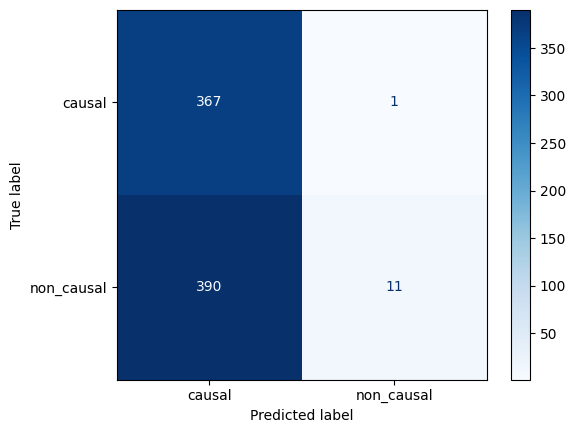

phi3:14b
0.652 & 0.612 & 0.58 & 0.585 & 0.657 & 0.618


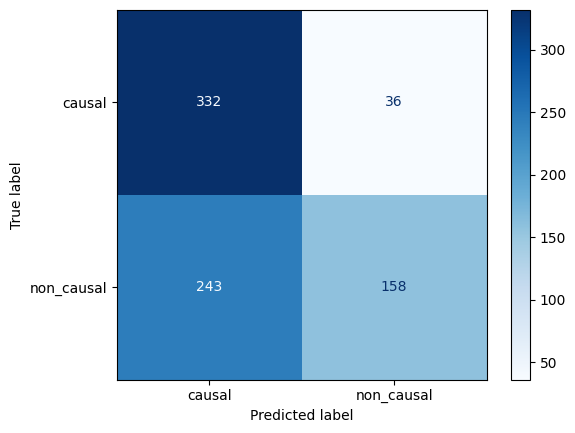

gemma2:27b
0.451 & 0.521 & 0.502 & 0.502 & 0.556 & 0.508


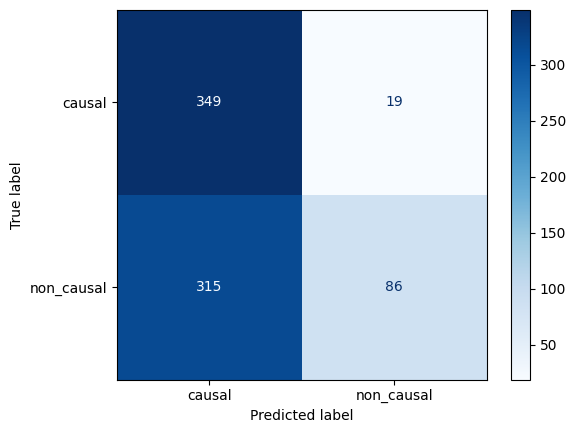

qwen2:7b
0.497 & 0.467 & 0.516 & 0.492 & 0.524 & 0.499


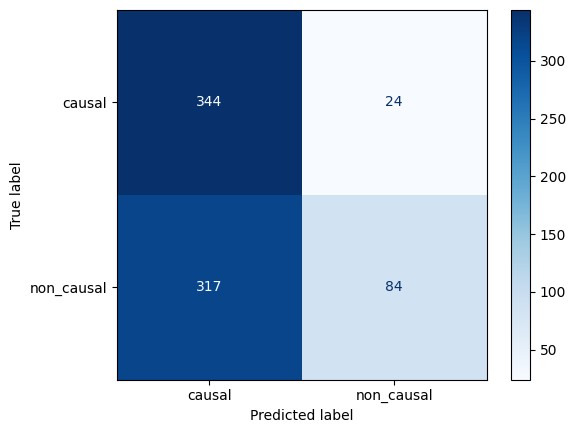

llama3:70b
0.511 & 0.596 & 0.506 & 0.568 & 0.553 & 0.548


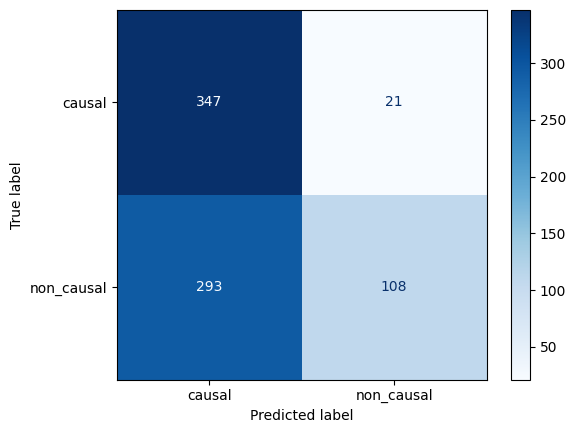

In [18]:
for model in ['llama3:8b', 'phi3:14b', 'gemma2:27b', 'qwen2:7b', 'llama3:70b']:
    print(model)
    df = pd.read_csv(model + '.csv') 
    graph = graph_modeling(df)
    fold_analysis(graph)